In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv(r'f_train.csv',encoding = 'gb2312')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 85 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 1000 non-null   int64  
 1   SNP1                               1000 non-null   int64  
 2   SNP2                               1000 non-null   int64  
 3   SNP3                               948 non-null    float64
 4   SNP4                               989 non-null    float64
 5   SNP5                               935 non-null    float64
 6   SNP6                               987 non-null    float64
 7   SNP7                               997 non-null    float64
 8   SNP8                               995 non-null    float64
 9   SNP9                               995 non-null    float64
 10  SNP10                              995 non-null    float64
 11  SNP11                              983 non-null    float6

In [4]:
### data preprocessing
# for most features: fill the missing value with median
cols = data.columns.values
for col in cols:
    if((col!='RBP4')
      and(col!='deliver time')):
        data[col] = data[col].fillna(data[col].median())
# for features missing too much: fill missing value with zero
data['RBP4'] = data['RBP4'].fillna(0)
data['deliver time'] = data['deliver time'].fillna(0)

In [5]:
#### feature engineering
data = data.drop(['id'], axis=1)
# remove features with zero std
remove = []
for column in data.columns:
    if data[column].std()==0:
        remove.append(column)
data = data.drop(remove, axis=1)
# remove abnormal features 
unique = []
for column in data.columns:
    num = len(data[column].unique())
    if data[column].isnull().sum()!=0:
        num -= 1
    if num == 1:
        unique.append(column)
data = data.drop(unique, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 84 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   SNP1                               1000 non-null   int64  
 1   SNP2                               1000 non-null   int64  
 2   SNP3                               1000 non-null   float64
 3   SNP4                               1000 non-null   float64
 4   SNP5                               1000 non-null   float64
 5   SNP6                               1000 non-null   float64
 6   SNP7                               1000 non-null   float64
 7   SNP8                               1000 non-null   float64
 8   SNP9                               1000 non-null   float64
 9   SNP10                              1000 non-null   float64
 10  SNP11                              1000 non-null   float64
 11  SNP12                              1000 non-null   float6

In [6]:
# filter high correlation
pd.set_option('display.max_rows', None)
corr_matrix = data.corr()
corr_matrix = corr_matrix['label'].sort_values(ascending=False)

In [7]:
pos_corr = list(corr_matrix[1:20].index)
neg_corr = list(corr_matrix[-15:].index)
cols = data.columns.values
for col in cols:
    if((col not in pos_corr) and(col not in neg_corr) and (col!='label')):
        data = data.drop(col, axis=1)

<AxesSubplot:xlabel='VAR00007'>

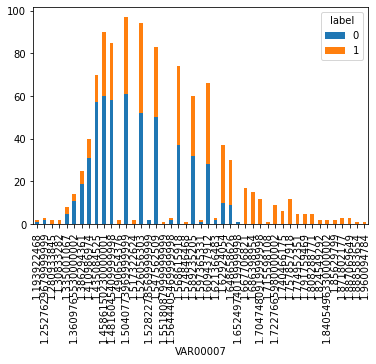

In [8]:
# examples about the relation between features and label
pd.crosstab(data.VAR00007,data.label).plot.bar(stacked = True)

In [9]:
data['SNP34'].value_counts()

1.0    541
2.0    319
3.0    140
Name: SNP34, dtype: int64

In [10]:
data['SNP37'].value_counts()

1.0    802
2.0    150
3.0     48
Name: SNP37, dtype: int64

In [11]:
data['fat'] = data['BMI before pregnancy']+data['weight before pregnancy']+data['TG']
data['blood pressure'] = data['systolic pressure']+data['diastolic pressure']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SNP10                    1000 non-null   float64
 1   SNP13                    1000 non-null   float64
 2   SNP17                    1000 non-null   float64
 3   SNP18                    1000 non-null   float64
 4   SNP19                    1000 non-null   float64
 5   SNP22                    1000 non-null   float64
 6   RBP4                     1000 non-null   float64
 7   age                      1000 non-null   float64
 8   gravidity                1000 non-null   float64
 9   parity                   1000 non-null   float64
 10  height                   1000 non-null   float64
 11  weight before pregnancy  1000 non-null   float64
 12  BMI class                1000 non-null   float64
 13  BMI before pregnancy     1000 non-null   float64
 14  systolic pressure        

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
# as the dataset in this experiment is small, we adapt 5-fold cross validation
# selected model: random forest
# model for comparison: logistic regression, svm, decision tree, naive bayes

# for random forest
gsrf_score_sum = 0
gsrf_best_score = 0
global gsrf, best_gsrf 
# for logistic regression
lr_score_sum = 0
lr_best_score = 0
global gslr, best_gslr
# for svm
svm_score_sum = 0
svm_best_score = 0
global svm, best_svm
# for decision tree
dt_score_sum = 0
dt_best_score = 0
global dt, best_dt
# for naive_bayes
gnb_score_sum = 0
gnb_best_score = 0
global gnb, best_gnb
# compare the performace of random forest classifer, logistic regression, svm, decision tree, and naive_bayes without fine-tune
kf =KFold(n_splits=5)
for train_index, test_index in kf.split(data):
    train, test = data.iloc[train_index], data.iloc[test_index]
    x_train = train.drop(['label'], axis=1)
    y_train = train['label']
    x_test = test.drop(['label'], axis=1)
    y_test = test['label']
    # for random forest
    gsrf = RandomForestClassifier(random_state=1)
    gsrf.fit(x_train,y_train)
    y_predict = gsrf.predict(x_test)
    score = f1_score(y_test, y_predict, average='micro')
    if score > gsrf_best_score: 
        gsrf_best_score = score
        best_gsrf = gsrf
    gsrf_score_sum = gsrf_score_sum + score
    # for logistic regression
    lr = LogisticRegression(penalty='l2', max_iter=10000)
    lr.fit(x_train, y_train)
    y_predict = lr.predict(x_test)
    score = f1_score(y_test, y_predict, average='micro')
    if score > lr_best_score: 
        lr_best_score = score
        best_lr = lr
    lr_score_sum = lr_score_sum + score
    # for svm
    svm = SVC()
    svm.fit(x_train, y_train)
    y_predict = svm.predict(x_test)
    score = f1_score(y_test, y_predict, average='micro')
    if score > svm_best_score: 
        svm_best_score = score
        best_svm = svm
    svm_score_sum = svm_score_sum + score
    # for decision tree
    dt = DecisionTreeClassifier(random_state=1)
    dt.fit(x_train, y_train)
    y_predict = dt.predict(x_test)
    score = f1_score(y_test, y_predict, average='micro')
    if score > dt_best_score:
        best_dt_score = score
        best_dt = dt
    dt_score_sum = dt_score_sum + score
    # for naive_bayes 
    gnb = GaussianNB()
    gnb.fit(x_train, y_train)
    y_predict = gnb.predict(x_test)
    score = f1_score(y_test, y_predict, average='micro')
    if score > gnb_best_score:
        best_gnb_score = score
        best_gnb = gnb
    gnb_score_sum = gnb_score_sum + score
gsrf_score_sum/=5
lr_score_sum/=5
svm_score_sum/=5
dt_score_sum/=5
gnb_score_sum/=5
print('logistic regression f1 score: ', lr_score_sum)
print('svm f1 score:', svm_score_sum)
print('naive bayes classifer f1 score:', gnb_score_sum)
print('decision tree classifer f1 score:', dt_score_sum)
print('random forest classifier f1 score: ', gsrf_score_sum)

logistic regression f1 score:  0.667
svm f1 score: 0.524
naive bayes classifer f1 score: 0.633
decision tree classifer f1 score: 0.601
random forest classifier f1 score:  0.674


In [14]:
# random forest classifer shows the best performance
# do fine tuning with grid search 
gsrf_score_sum = 0
gsrf_best_score = 0
kf =KFold(n_splits=5)
for train_index, test_index in kf.split(data):
    train, test = data.iloc[train_index], data.iloc[test_index]
    x_train = train.drop(['label'], axis=1)
    y_train = train['label']
    x_test = test.drop(['label'], axis=1)
    y_test = test['label']
    # for random forest
    rf = RandomForestClassifier(random_state=1)
    prf = [{'n_estimators':[10,50,100,150],'max_depth':[3,6,9,12],'criterion':['gini','entropy']}]
    gsrf = GridSearchCV(estimator = rf, param_grid = prf,scoring = 'accuracy',cv = 2)
    gsrf.fit(x_train,y_train)
    print(gsrf.best_params_)
    y_predict = gsrf.predict(x_test)
    score = f1_score(y_test, y_predict, average='micro')
    print(score)
    if score > gsrf_best_score: 
        gsrf_best_score = score
        best_gsrf = gsrf
    gsrf_score_sum = gsrf_score_sum + score
gsrf_score_sum/=5
print('random forest classfier f1 score after fine tuning: ', gsrf_score_sum)

{'criterion': 'gini', 'max_depth': 3, 'n_estimators': 150}
0.705
{'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 100}
0.675
{'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 50}
0.715
{'criterion': 'gini', 'max_depth': 3, 'n_estimators': 10}
0.665
{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 50}
0.645
random forest classfier f1 score after fine tuning:  0.6809999999999999
